Global seed set to 4944


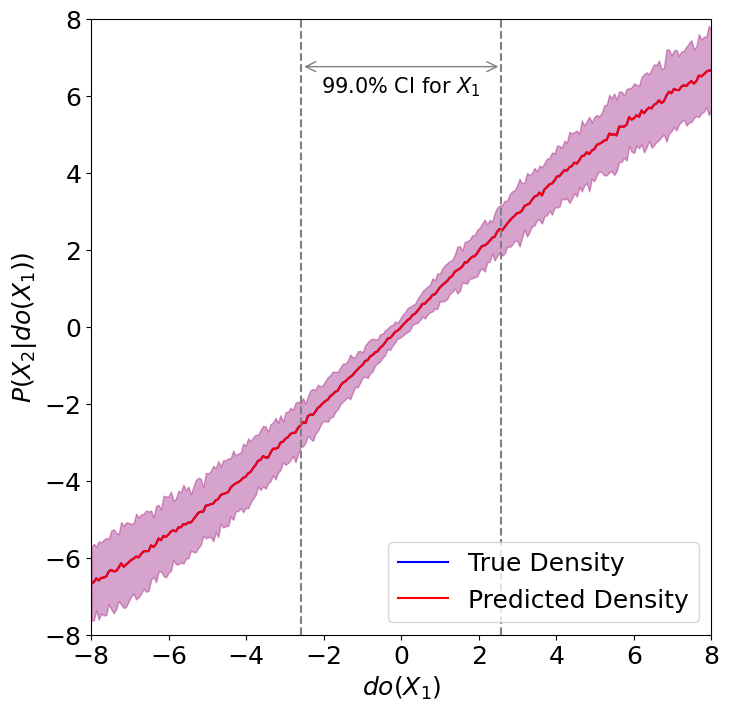

In [2]:
# %load_ext autoreload
# %autoreload 2
# set PYTORCH_ENABLE_MPS_FALLBACK=1 in your environment

import os
import sys

sys.path.append("../..")
import seaborn as sns

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import matplotlib.pyplot as plt
import yaml
import lightning_toolbox as ltb
from lightning import seed_everything

seed_everything(4944)
import dypy as dy
from ocd.data import InterventionChainDataset
from ocd.training.callbacks.intervention import draw, draw_grid

# create a random permutation of n numbers
n = 5
checkpoint = "epoch=2999-step=108000"

# paths
model_path = "./config/main.yml"
data_path = f"./data/main.yml"
checkpoint_path = f"./fixedv7/checkpoints/{n}/{checkpoint}.ckpt"

# configs
data_config = yaml.safe_load(open(data_path, "r"))
# model_config = yaml.safe_load(open(model_path, "r"))["model"]
# model_config["init_args"]["model_args"]["in_features"] = n

# data
dataset = InterventionChainDataset(**data_config["init_args"]["dataset_args"])

# model
# model = dy.eval(model_config["class_path"])(**model_config["init_args"])
# model.load_state_dict(torch.load(checkpoint_path, map_location="cpu")["state_dict"])
# flow = model.model.flow

# hyper params
k = 8
num_interventions = 250
num_samples = 50


values = torch.linspace(-k, k, num_interventions)
# with torch.no_grad():
# pred_samples = flow.do(0, values, num_samples=num_samples)
gt_samples = dataset.do(0, values, num_samples=num_samples)
# pred_mean = pred_samples.mean(-2)
# pred_std = pred_samples.std(-2)
gt_mean = gt_samples.mean(-2)
gt_std = gt_samples.std(-2)


# draw_interventions_grid(
#     values=values,
#     # pred_means=pred_mean,
#     # pred_stds=pred_std,
#     gt_means=gt_mean,
#     gt_stds=gt_std,
#     targets=[0, 1, 2, 3, 4],
#     percentile=0.95,
#     limit_y=0.5,
#     limit_ys=[-8, 8],
# )
percentile = 0.99
if percentile > 0:
    cis = [(1 - percentile) / 2, 1 - (1 - percentile) / 2]
    icis = dataset.base_distribution.icdf(torch.tensor(cis)).detach().cpu()
_ = draw(
    fig=plt.figure(figsize=(8, 8)),
    k=k,
    n=n,
    values=values,
    limit_ys=[-8, 8],
    pred_means=gt_mean,
    pred_stds=gt_std,
    gt_means=gt_mean,
    gt_stds=gt_std,
    target=1,
    percentile=percentile,
    icis=icis,
    limit_y=0.5,
)

In [78]:
def create_intervention(value):
    def intervention_function(*args, **kwargs):
        return value

    return intervention_function


def scm_intervention(num_samples, value, **kwargs):
    cfg = data_config["init_args"]["dataset_args"]
    cfg = {**cfg, "observation_size": num_samples, "standardization": False}

    data = SyntheticOCDDataset(
        **cfg,
        intervention_nodes=[0],
        intervention_functions=[create_intervention(value)],
    )
    idata = data.samples.to_numpy()
    # print(idata.shape)
    return torch.tensor(idata)


def true_hard_ate(do=0, target=-1, k=1.5, range_samples=1000, num_samples=100, **kwargs):
    values = torch.linspace(-k, k, range_samples)
    ate = torch.stack([scm_intervention(num_samples, value.item(), **kwargs)[:, target] for value in values], dim=0)
    return values, ate.mean(dim=1), ate.std(dim=1)


values, true_ate, true_ate_std = true_hard_ate()